<a href="https://colab.research.google.com/github/gaurikapoplai21/CCBD-Project/blob/master/AN4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# OS setup
!cat /etc/os-release
!apt-get install -qq bc tree sox

# espnet setup
!git clone --depth 5 https://github.com/espnet/espnet
!pip install -q torch==1.5.1
!cd espnet; pip install -q -e .

# download pre-compiled warp-ctc and kaldi tools
!espnet/utils/download_from_google_drive.sh \
    "https://drive.google.com/open?id=13Y4tSygc8WtqzvAVGK_vRV9GlV7TRC0w" espnet/tools tar.gz > /dev/null
!cd espnet/tools/warp-ctc/pytorch_binding && \
    pip install -U dist/warpctc_pytorch-0.1.1-cp36-cp36m-linux_x86_64.whl

# make dummy activate
!mkdir -p espnet/tools/venv/bin && touch espnet/tools/venv/bin/activate
!echo "setup done."

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic
Selecting previously unselected package libopencore-amrnb0:amd64.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../0-libopencore-amrnb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../1-libopencore-amrwb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libmagic-mgc.
Preparing to unpack .../2-libmagic-mgc_1%3a5.32-2ubuntu0.4_amd64.deb ...
Unpacking libmagic-mgc (1:5.32-2ubuntu0.4)

In [2]:
# move on the recipe directory
import os
os.chdir("/content/espnet/egs/an4/asr1")

# check files
!tree -L 1

.
├── cmd.sh
├── conf
├── local
├── path.sh
├── RESULTS
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

4 directories, 4 files


In [3]:
# run stage -1 and then stop
!./run.sh --stop_stage 2

stage -1: Data Download
local/download_and_untar.sh: downloading data (64 MB) from http://www.speech.cs.cmu.edu/databases/an4//an4_sphere.tar.gz.
--2020-06-24 19:19:18--  http://www.speech.cs.cmu.edu/databases/an4//an4_sphere.tar.gz
Resolving www.speech.cs.cmu.edu (www.speech.cs.cmu.edu)... 128.2.204.214
Connecting to www.speech.cs.cmu.edu (www.speech.cs.cmu.edu)|128.2.204.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64327561 (61M) [application/x-gzip]
Saving to: 'an4_sphere.tar.gz'

an4_sphere.tar.gz   100%[===================>]  61.35M  16.4MB/s    in 5.1s    

2020-06-24 19:19:23 (12.1 MB/s) - 'an4_sphere.tar.gz' saved [64327561/64327561]

local/download_and_untar.sh: line 57: cd: ./downloads: No such file or directory
an4/
an4/README
an4/etc/
an4/etc/an4_test.fileids
an4/etc/an4.ug.lm
an4/etc/an4.ug.lm.DMP
an4/etc/an4_train.fileids
an4/etc/an4_train.transcription
an4/etc/an4_test.transcription
an4/etc/an4.dic
an4/etc/an4.phone
an4/etc/an4.filler
an4/

In [4]:
# it takes 2 minutes
!./run.sh  --ngpu 1 --stage 3 --stop-stage 3

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: LM Preparation


In [5]:
# check the LM perplexity
!cat exp/train_rnnlm_pytorch_lm_word100/train.log | grep perplexity

2020-06-24 19:27:26,851 (lm:400) INFO: test perplexity: 13.923704908073123


In [6]:
!cat /content/espnet/egs/an4/asr1/conf/train_mtlalpha0.5.yaml

# minibatch related
batch-size: 30
maxlen-in: 800  # if input length  > maxlen_in, batchsize is automatically reduced
maxlen-out: 150 # if output length > maxlen_out, batchsize is automatically reduced
# optimization related
sortagrad: 0 # Feed samples from shortest to longest ; -1: enabled for all epochs, 0: disabled, other: enabled for 'other' epochs
opt: adadelta
epochs: 20
patience: 3

# scheduled sampling option
sampling-probability: 0.0

# encoder related
etype: blstmp     # encoder architecture type
elayers: 4
eunits: 320
eprojs: 320
subsample: "1_2_2_1_1" # skip every n frame from input to nth layers
# decoder related
dlayers: 1
dunits: 300
# attention related
atype: location
adim: 320
aconv-chans: 10
aconv-filts: 100

# hybrid CTC/attention
mtlalpha: 0.5


In [5]:
# WARNING: This code takes 5-6 minutes!
!./run.sh  --ngpu 1 --stage 4 --stop-stage 4 --train-config conf/train_mtlalpha0.5.yaml

dictionary: data/lang_1char/train_nodev_units.txt
stage 4: Network Training


In [6]:
!grep -e groundtruth -e prediction exp/train_nodev_pytorch_train_mtlalpha0.5/train.log \
  | sed -e 's/<eos>//g' -e 's/<space>/ /g' | head -n 20

2020-06-23 17:39:15,132 (decoders:300) INFO: groundtruth[0]: FOUR TWO TWO TWO OH EIGHT NINE
2020-06-23 17:39:15,132 (decoders:301) INFO: prediction [0]: KKAAAHHDFWQDFWDDDDQOKKAOCCCCALL
2020-06-23 17:39:15,132 (decoders:300) INFO: groundtruth[1]: JUNE TWENTY THIRD NINETEEN SIXTY NINE
2020-06-23 17:39:15,132 (decoders:301) INFO: prediction [1]: KNNLLLJDMLLDDDDACHHDLLLLLLLLLLLXXRLLL
2020-06-23 17:39:15,132 (decoders:300) INFO: groundtruth[2]: J O S E P H
2020-06-23 17:39:15,132 (decoders:301) INFO: prediction [2]: KNHHWWWWWWWR
2020-06-23 17:39:15,132 (decoders:300) INFO: groundtruth[3]: ONE FIVE TWO ONE THREE
2020-06-23 17:39:15,132 (decoders:301) INFO: prediction [3]: KKPLWKAKVHLDFHQQLWLAKKK
2020-06-23 17:39:15,132 (decoders:300) INFO: groundtruth[4]: ONE FIVE TWO THREE TWO
2020-06-23 17:39:15,132 (decoders:301) INFO: prediction [4]: KKPLWKAKVHLDFHDAKKKKLDK
2020-06-23 17:39:15,540 (decoders:300) INFO: groundtruth[0]: S T O D O L S K Y
2020-06-23 17:39:15,540 (decoders:301) INFO: predicti

In [11]:
!grep -e groundtruth -e prediction exp/train_nodev_pytorch_train_mtlalpha0.5/train.log \
  | sed -e 's/<eos>//g' -e 's/<space>/ /g' | tail -n 20

2020-06-23 13:03:22,463 (decoders:300) INFO: groundtruth[0]: TWO FIFTEEN SIXTY TWO
2020-06-23 13:03:22,463 (decoders:301) INFO: prediction [0]: TWO SIVTYE  SIXTY SWO 
2020-06-23 13:03:22,463 (decoders:300) INFO: groundtruth[1]: O U FOUR SEVEN TWENTY NINE
2020-06-23 13:03:22,463 (decoders:301) INFO: prediction [1]: M N R UR NEVEN NWENTY NINE
2020-06-23 13:03:22,463 (decoders:300) INFO: groundtruth[2]: TWO FIVE TWO TWO OH TWO NINE
2020-06-23 13:03:22,463 (decoders:301) INFO: prediction [2]: TWO FIVE TWO TWO TN TWO TINE 
2020-06-23 13:03:22,463 (decoders:300) INFO: groundtruth[3]: ELEVEN NINE SIXTY EIGHT
2020-06-23 13:03:22,463 (decoders:301) INFO: prediction [3]: NNVNEN NINE NIX Y NIGHT 
2020-06-23 13:03:22,463 (decoders:300) INFO: groundtruth[4]: ONE FIVE TWO ONE SEVEN
2020-06-23 13:03:22,463 (decoders:301) INFO: prediction [4]: ONE FIVE TWO ONE SEVEN
2020-06-23 13:03:22,674 (decoders:300) INFO: groundtruth[0]: NO
2020-06-23 13:03:22,674 (decoders:301) INFO: prediction [0]: NO
2020-06-2

acc.png


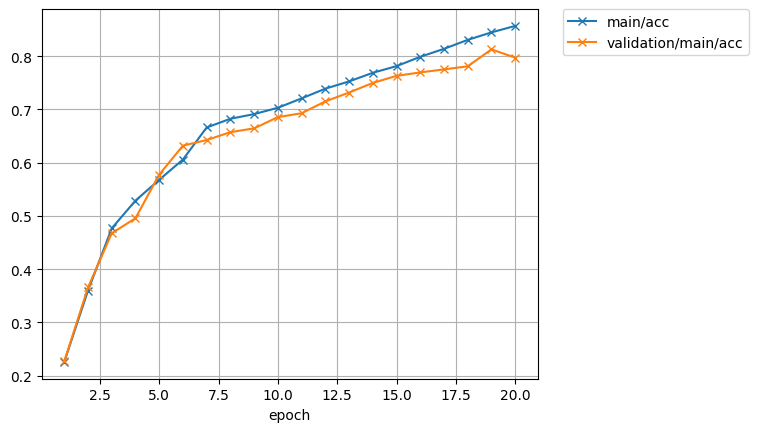

In [12]:
import glob
from IPython.display import Image, display_png
expdir = "exp/train_nodev_pytorch_train_mtlalpha0.5/results/"
for name in ["acc.png"]:
    print(name)
    display_png(Image(expdir + name, width=500))

In [13]:
!cat conf/decode_ctcweight0.5.yaml

# decoding parameter
beam-size: 20
penalty: 0.0
maxlenratio: 0.0
minlenratio: 0.0
ctc-weight: 0.5
lm-weight: 1.0


In [14]:
# WARNING: This code takes 6 minutes!
# Only recognize the test set
!sed -i.bak -e's/recog_set="train_dev test"/recog_set="test"/' run.sh
# run the actual recognition script
!./run.sh --stage 5 --decode-config conf/decode_ctcweight0.5.yaml --train-config conf/train_mtlalpha0.5.yaml

dictionary: data/lang_1char/train_nodev_units.txt
stage 5: Decoding
2020-06-23 13:07:32,848 (splitjson:43) INFO: /usr/bin/python3 /content/espnet/egs/an4/asr1/../../../utils/splitjson.py --parts 8 dump/test/deltafalse/data.json
2020-06-23 13:07:32,869 (splitjson:55) INFO: number of utterances = 130
2020-06-23 13:11:42,561 (concatjson:36) INFO: /usr/bin/python3 /content/espnet/egs/an4/asr1/../../../utils/concatjson.py exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_lm_word100/data.1.json exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_lm_word100/data.2.json exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_lm_word100/data.3.json exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_lm_word100/data.4.json exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_lm_word100/data.5.json exp/train_nodev_pytorch_train_mtlalpha0.5/decode_test_decode_ctcweight0.5_lm_word100/data.6.js